# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [88]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

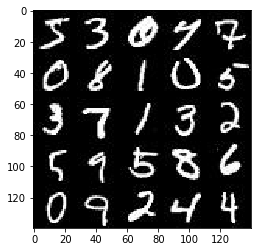

In [90]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

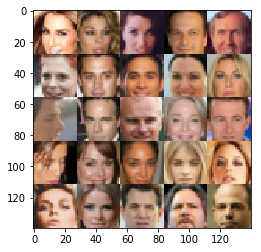

In [91]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [92]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/liuyizhe/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [93]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="inputs_real")
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name="inputs_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return real_inputs, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [119]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator",reuse=reuse):
       
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(),padding='same')
        relu1 = tf.maximum(0.1 * x1, x1)
       
        #14*14*64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(),padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        #7*7*128
        
        #4*4*256
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        #flat = tf.nn.dropout(flat,0.8)
        logits = tf.layers.dense(flat, 1)
      
        out = tf.sigmoid(logits)

    return  out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [120]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
   
    reuse = False
    if is_train:
        reuse = False
    else:
        reuse = True
    with tf.variable_scope("generator",reuse=reuse):
        # First fully connected layer
       
        x1 = tf.layers.dense(z, 7*7*256)
        #x1 = tf.nn.dropout(x1,0.8)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1,128,5,strides=2,
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
       
       
        # 14x14x128
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2,
                                           padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [121]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim,True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                     logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_logits_real,labels=tf.ones_like(d_logits_real)*0.8))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [122]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    m_vars = tf.trainable_variables()
    d_var = [var for var in m_vars if var.name.startswith("discriminator")]
    g_var = [var for var in m_vars if var.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
        g_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [123]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [124]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
 
    channel = None
    if data_image_mode == "RGB":
        channel = 3
    else:
        channel = 1
 
    input_real, input_z ,lr = model_inputs(data_shape[1], data_shape[2], channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt ,g_train_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 1 
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size = (batch_size,z_dim))
        
                sess.run(d_train_opt,feed_dict = {input_real:batch_images,input_z:batch_z,lr:learning_rate})
                sess.run(g_train_opt,feed_dict = {input_real:batch_images,input_z:batch_z,lr:learning_rate})
                if ii % 100 == 0:
                    show_generator_output(sess, 3, input_z, channel, data_image_mode)
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                ii+=1
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

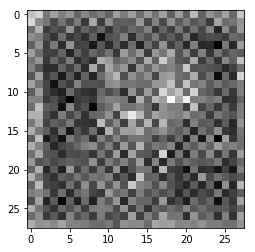

Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.2828


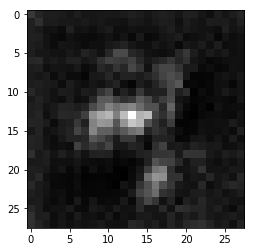

Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.2196


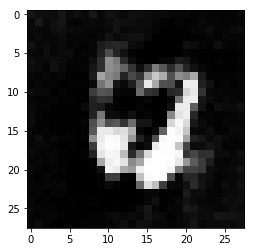

Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 1.3669


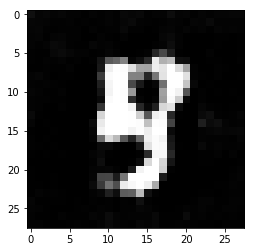

Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.9930


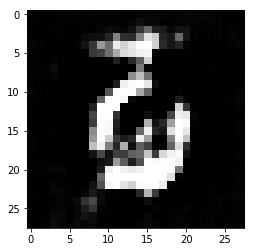

Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 1.3798


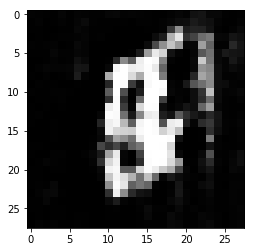

Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.3237


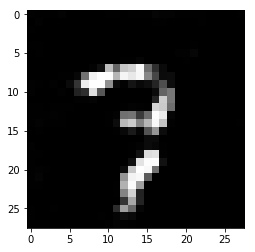

Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 1.7003


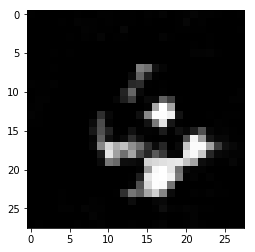

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.9581


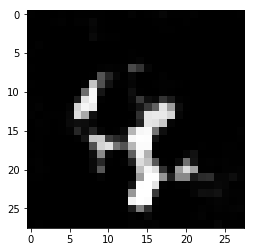

Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.5371


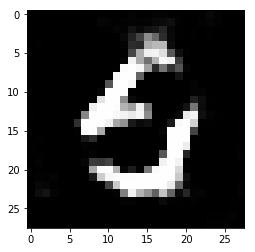

Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.1700


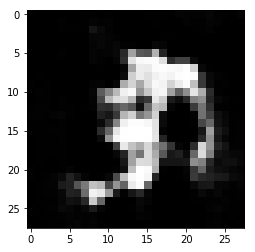

Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.2640


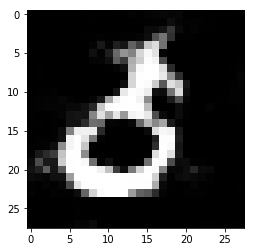

Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.2897


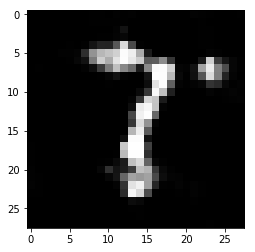

Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 1.0193


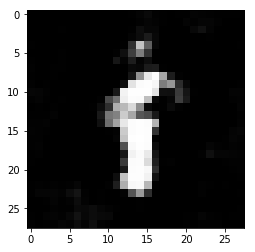

Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.3656


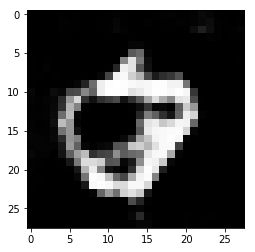

Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 1.0017


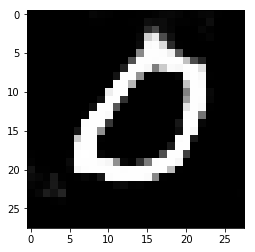

Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 1.2072


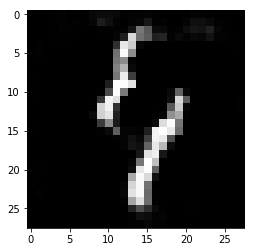

Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.2827


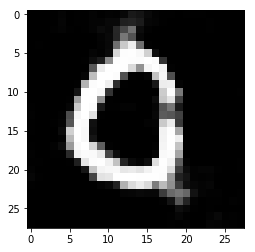

Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 1.2732


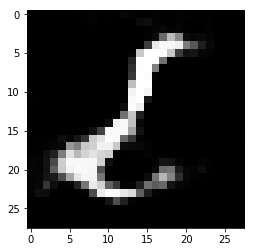

Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.2352


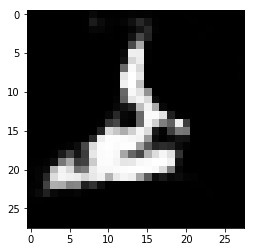

Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.1483


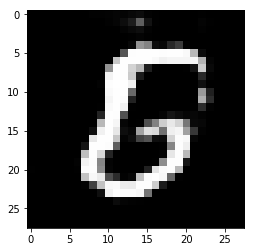

Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 1.2486


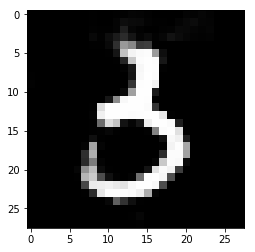

Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 1.1302


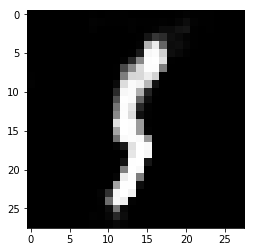

Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.2153


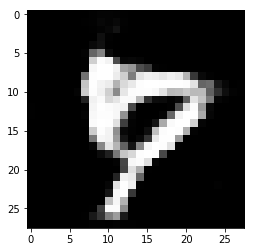

Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.2431


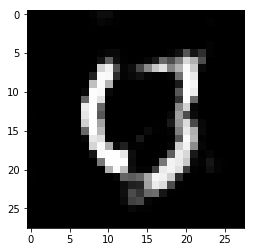

Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.4017


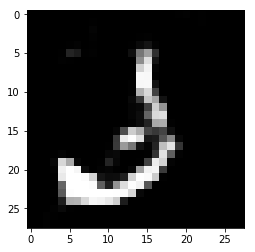

Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.9860


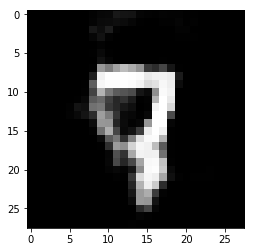

Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 1.5450


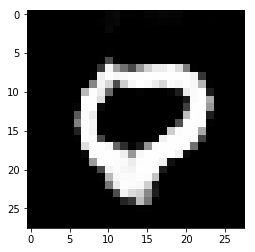

Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.1217


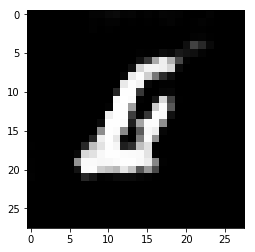

Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 1.2050


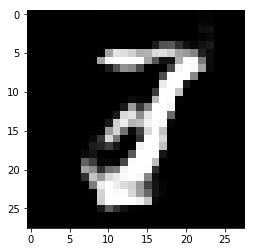

Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.2451


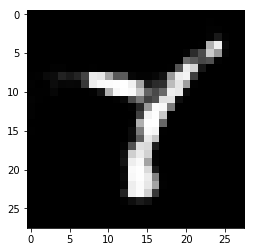

Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.3548


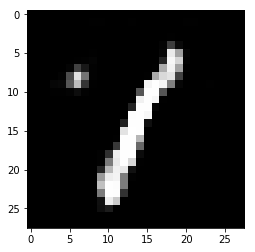

Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.3741


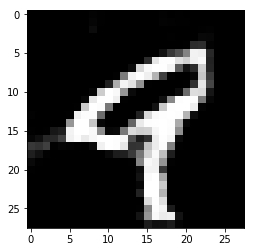

Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 1.8726


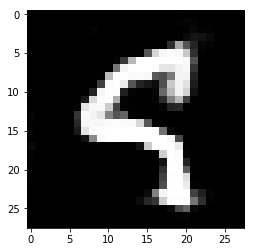

Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.4233


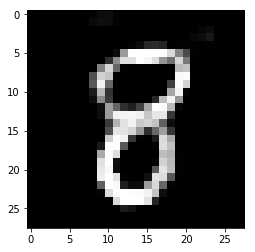

Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.4572


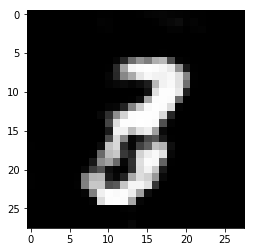

Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.8715


In [125]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

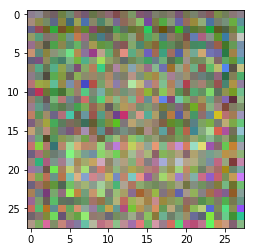

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2402


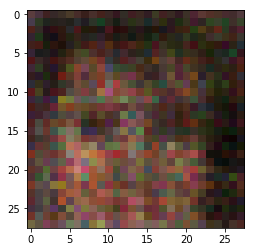

Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.3708


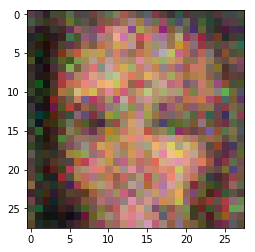

Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.8737


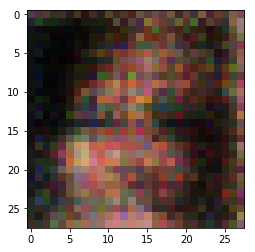

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.0060


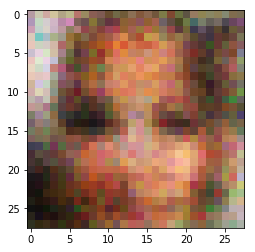

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.1179


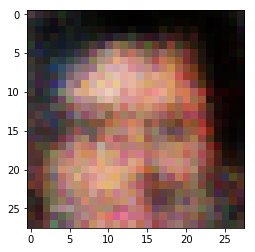

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.2770


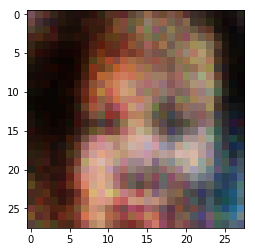

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9823


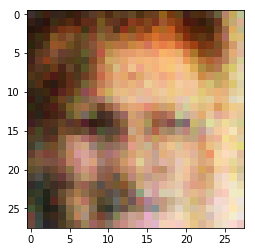

Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.0336


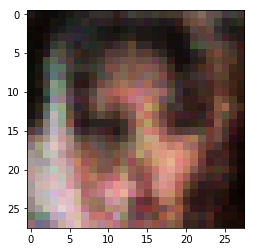

Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.3904


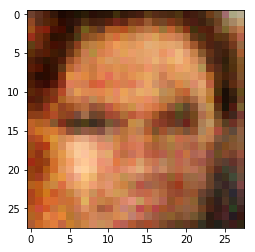

Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.3171


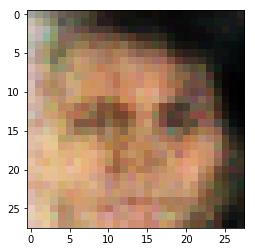

Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.2796


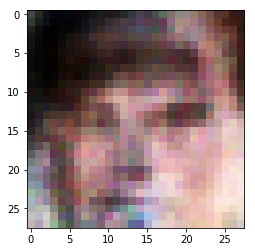

Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.2040


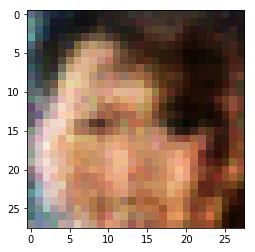

Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.1785


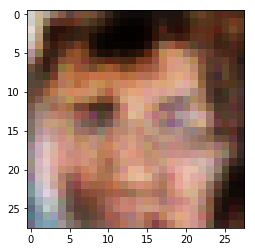

Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.4504


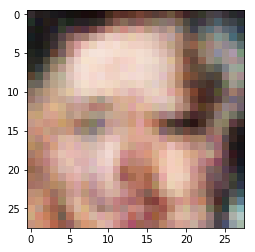

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7490


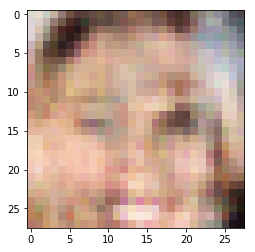

Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.0276


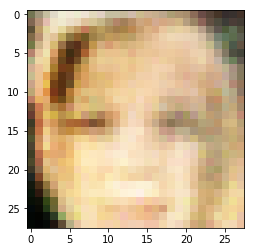

Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0287


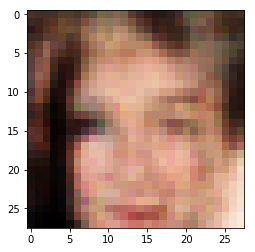

Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.1567


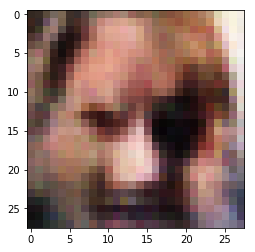

Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.2146


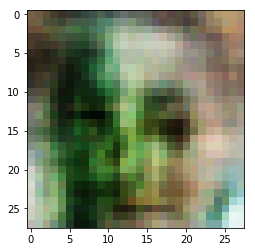

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8618


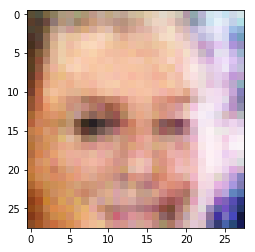

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.9256


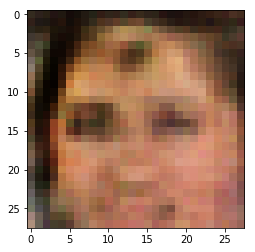

Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9841


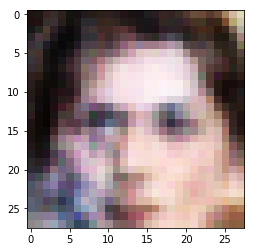

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.9656


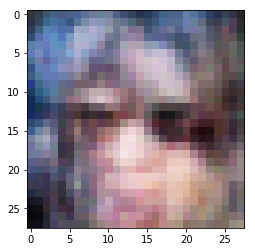

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9375


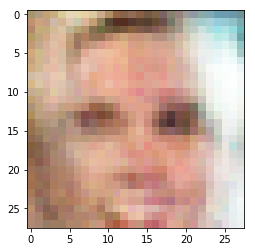

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9799


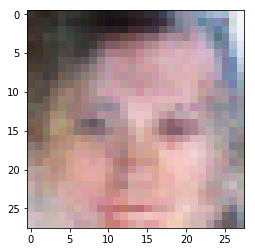

Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.1710


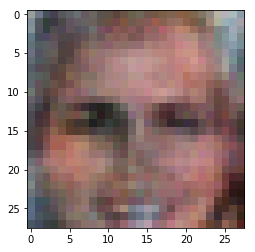

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.9720


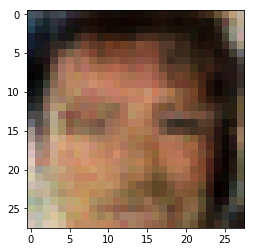

Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.0480


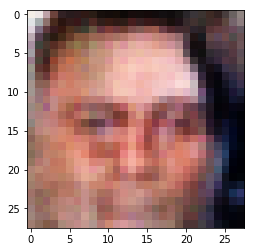

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7252


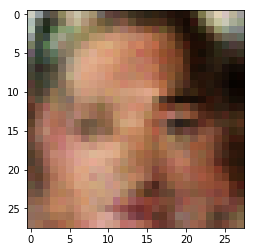

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9175


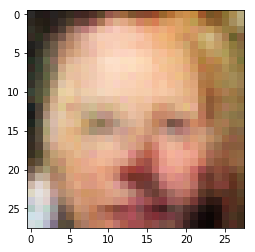

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.1134


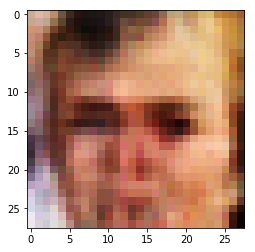

Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 1.0008


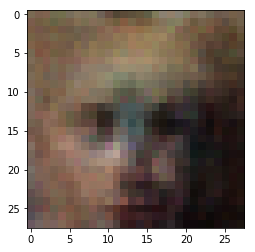

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.0642


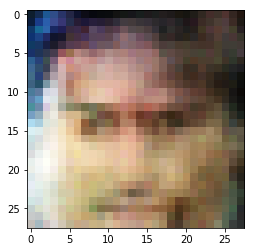

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8167


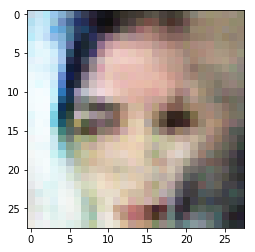

Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.8252


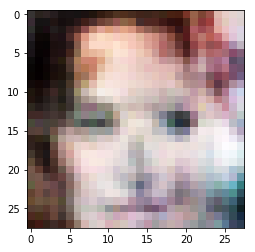

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.0820


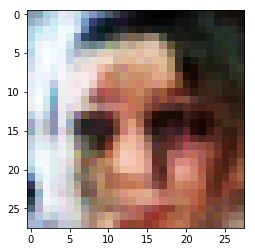

Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.1203


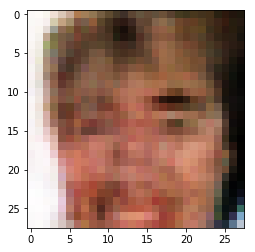

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8729


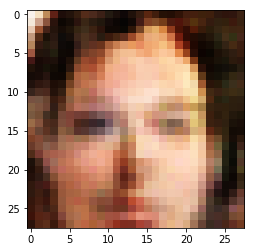

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8776


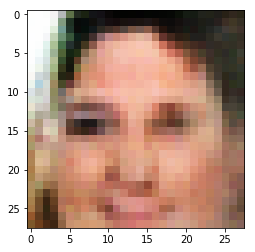

Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.0092


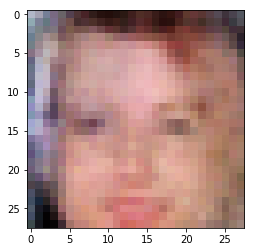

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0300


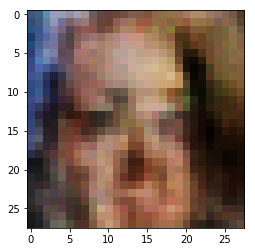

Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.9214


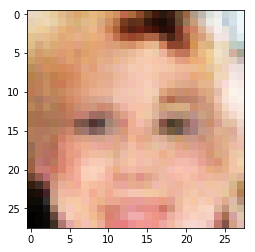

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.9986


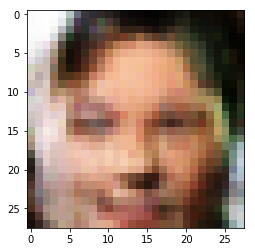

Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8829


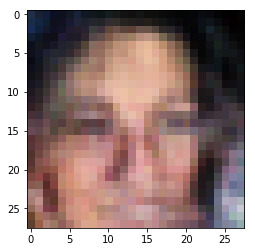

Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7834


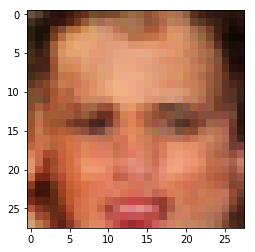

Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8834


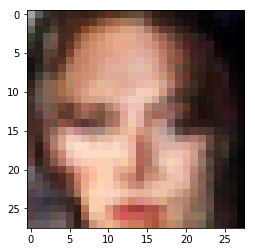

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7823


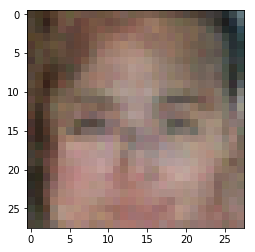

Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.1796


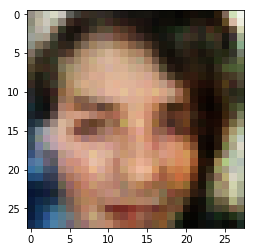

Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.1868


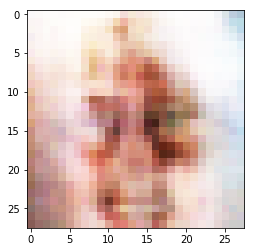

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.9818


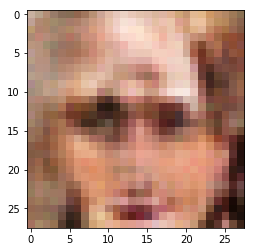

Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9579


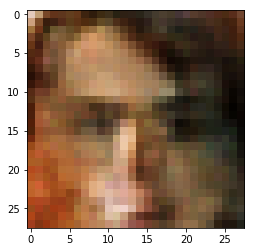

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8630


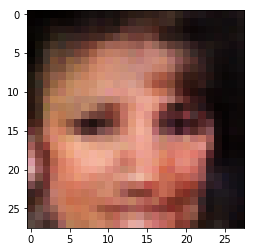

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8705


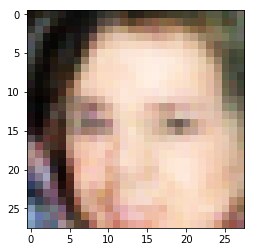

Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8799


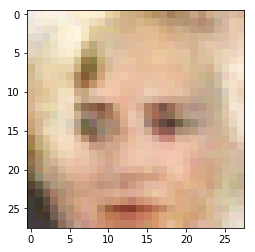

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.0856


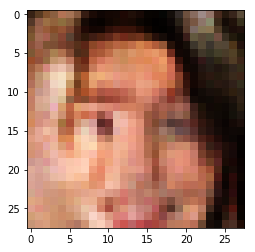

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9316


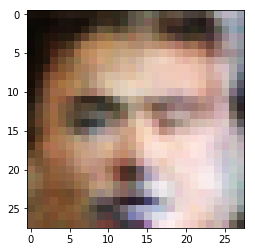

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7430


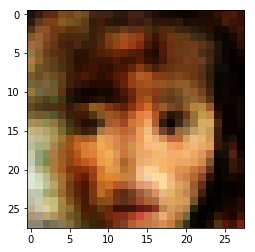

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.8814


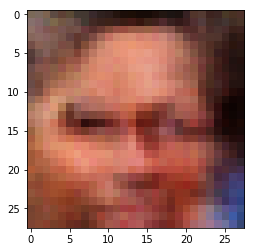

Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.1411


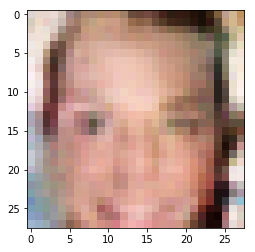

Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.9611


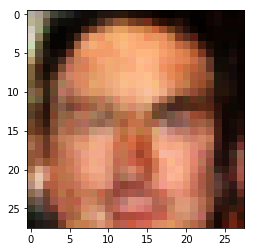

Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.2733


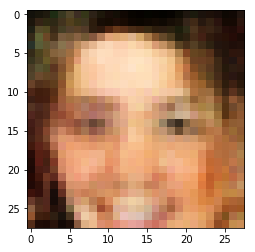

Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.8067


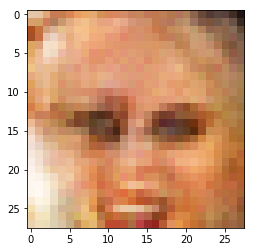

Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.0849


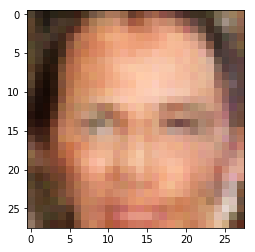

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7622


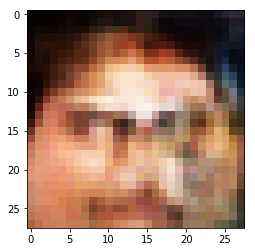

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9116


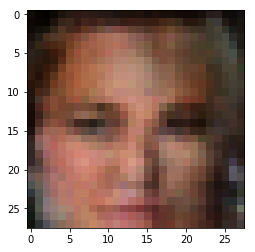

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1751


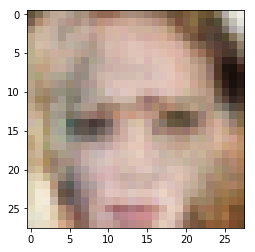

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7715


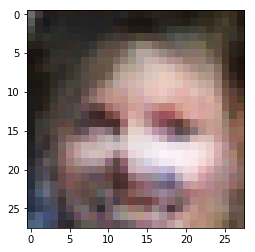

Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8964


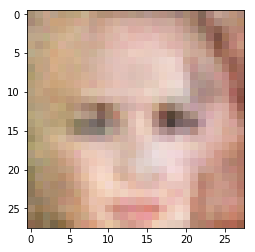

Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 1.2168


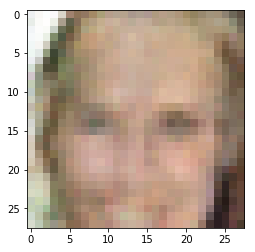

Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.9259


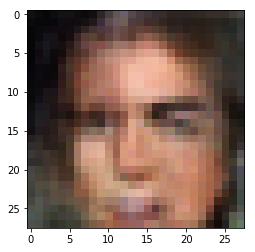

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8534


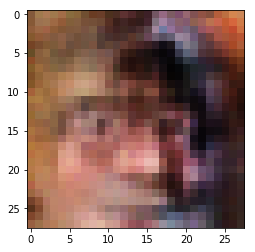

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8810


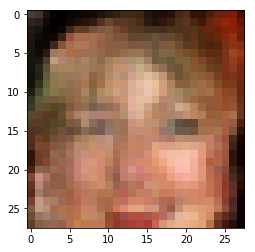

Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9699


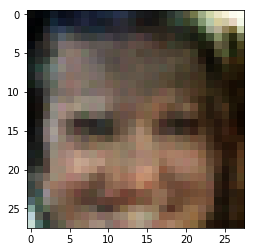

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9079


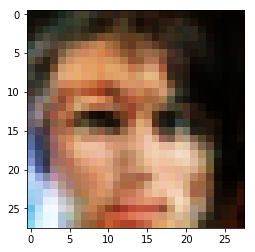

Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.9634


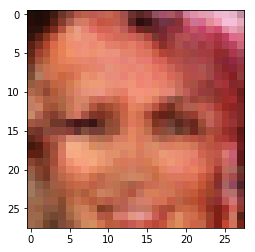

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9684


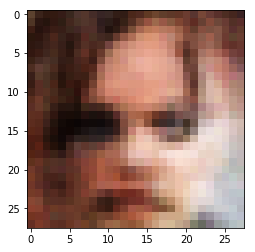

Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.1483


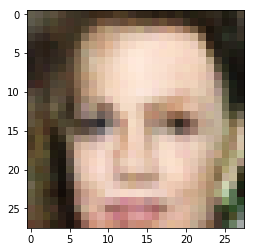

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8544


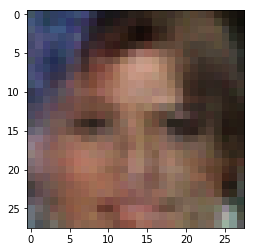

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.3743


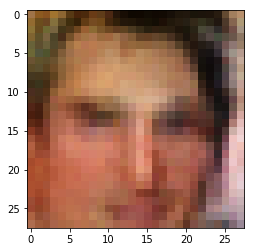

Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.0785


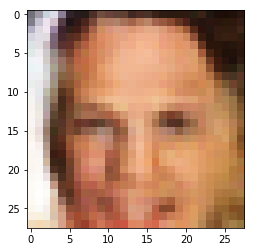

Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8429


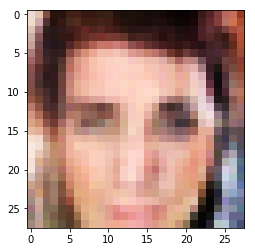

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8344


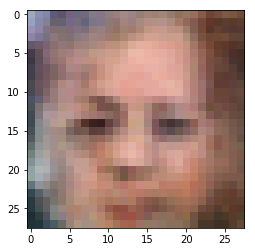

Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.0136


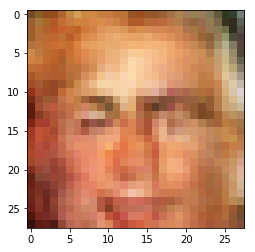

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.9755


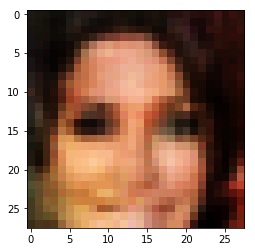

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1065


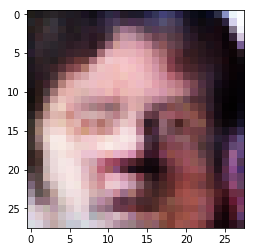

Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.7469


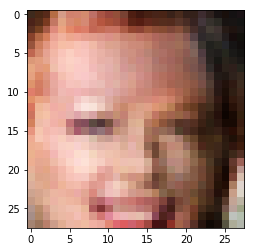

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.9963


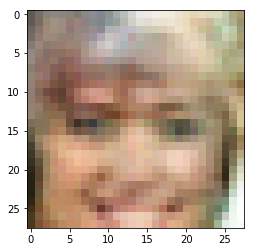

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0659


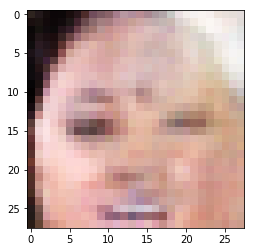

Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8447


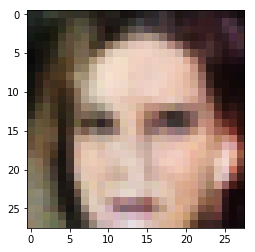

Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.0958


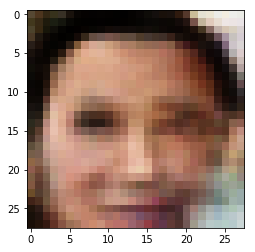

Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.0761


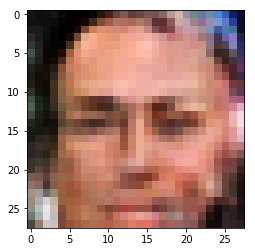

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.9555


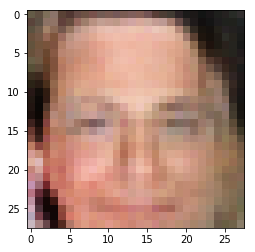

Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0134


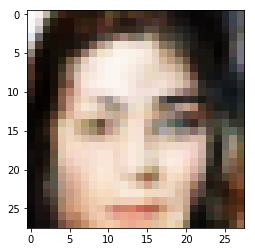

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8842


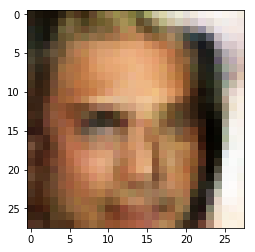

Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.2225


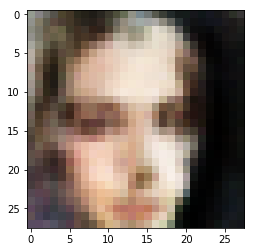

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.2442


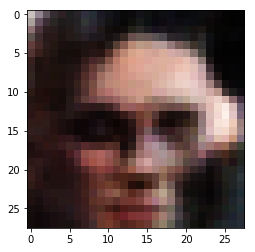

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8713


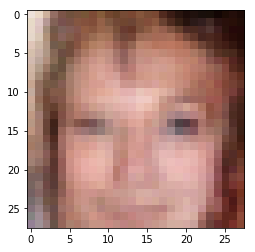

Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0600


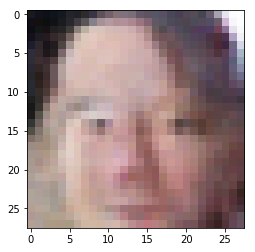

Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.0296


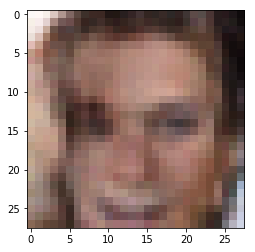

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.5559


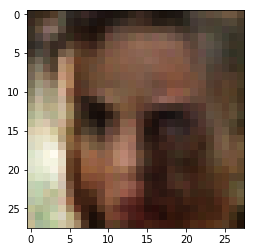

Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9487


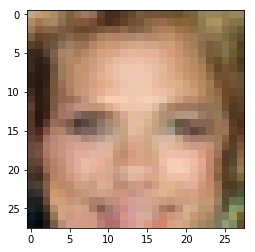

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9257


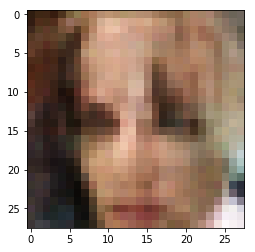

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7937


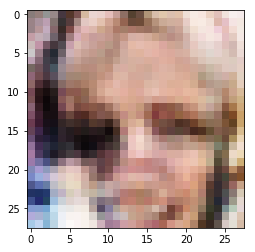

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.0217


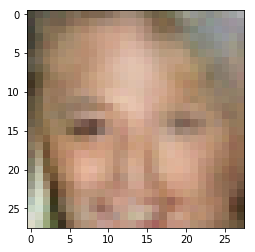

Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.4826


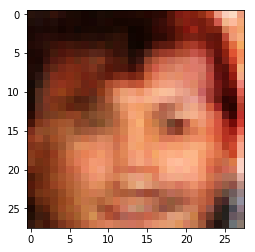

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.1596


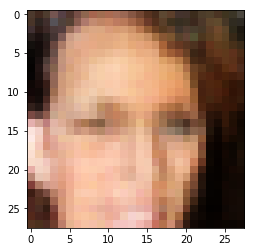

Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.3106


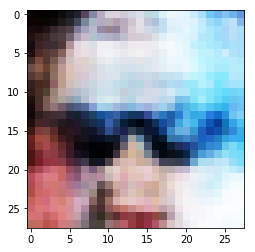

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9652


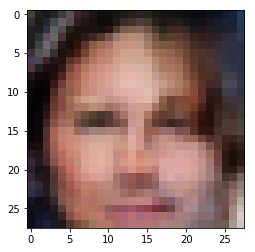

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.1693


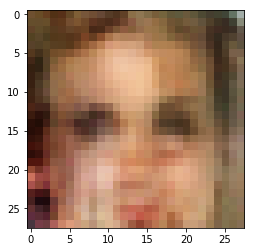

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.0461


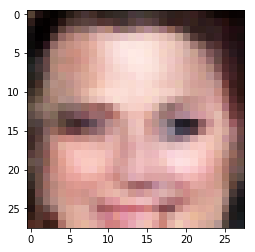

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.1100


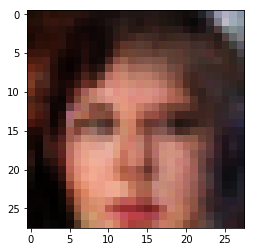

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.2614


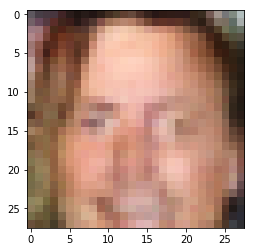

Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.2287


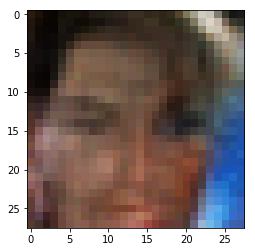

Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.4285


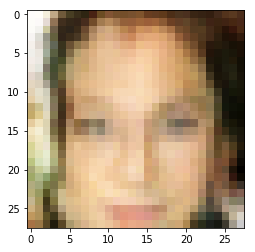

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8247


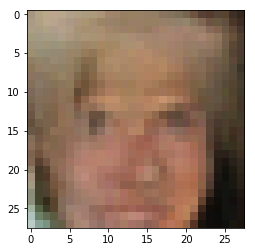

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9460


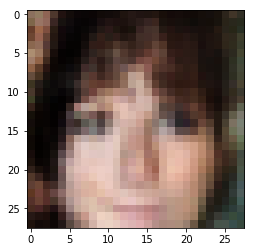

Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.0349


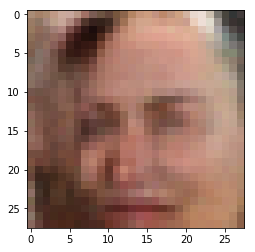

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.0599


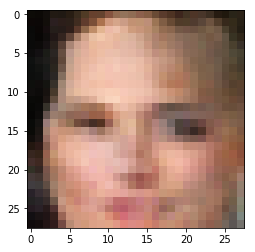

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.9697


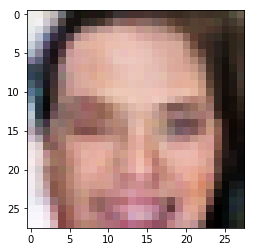

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.9670


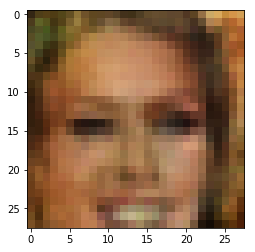

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8614


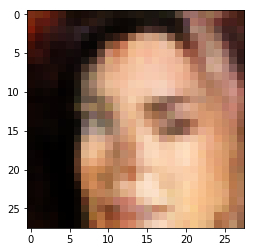

Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.0127


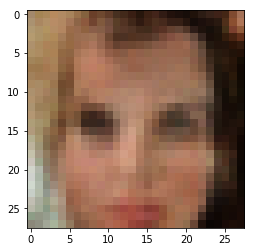

Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8497


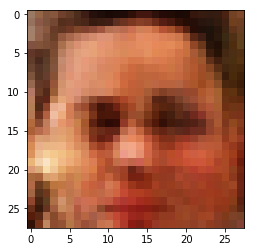

Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8338


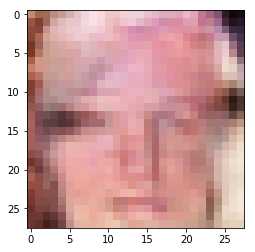

Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.9764


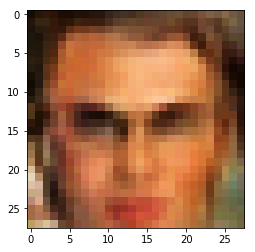

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7530


In [126]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。